# Twitter dataset analysis

## Run pipelines

In [1]:
# IMPORTS
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
from pipelines import Orchestrator
from analysis_helper import AnalysisHelper

INFO - datasources.tw.tw - load config file
INFO - datasources.tw.proxy_provider - getting proxy list
INFO - datasources.tw.proxy_provider - reading proxy list json file
DEBUG - datasources.tw.tw_api - INIT Tw api
DEBUG - datasources.tw.tw_premium_api - INIT Tw premium api
INFO - datasources.tw.tw - INIT Tw
DEBUG - matplotlib.pyplot - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
# LOGGING LEVEL
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
# CONFIGS
project_name = 'uk_healthcare'

# cd_config = ('infomap', {})
cd_config = ('demon', {
    'epsilon': 0.25,
    'min_community_size': 3
})

In [4]:
# PIPELINE
o = Orchestrator(project_name, cd_config)
results = o.execute()

## Analysis

### Event and graph analysis

#### Events summary

In [5]:
display(AnalysisHelper.get_single_summary('event_detection', 'event', results))

,end_date,hashtags,location,start_date
name,,,,
16-days-of-action-2018,2018-12-10,"[#16days, #16daysofaction, #16daysofactiontool...",United Kingdom,2018-11-25
elf-day,2018-12-12,"[#elfday, #elfday2018]",United Kingdom,2018-12-03
dry-january-2018,2018-01-31,[#dryjanuary],United Kingdom,2018-01-01
cervical-cancer-prevention-week-2018,2018-01-27,[#cervicalcancer],United Kingdom,2018-01-21
time-to-talk-day-2018,2018-02-07,[#timetotalk],United Kingdom,2018-02-06
eating-disorder-awareness-week-2018,2018-03-03,"[#edaw18, #edaw2018, #eatingdisordersawareness...",United Kingdom,2018-02-25
rare-disease-day-2018,2018-03-01,[#rarediseaseday],United Kingdom,2018-02-28
ovarian-cancer-awareness-month-2018,2018-03-31,"[#ovariancancer, #ovariancancerawareness, #ova...",United Kingdom,2018-03-01
nutrition-and-hydration-week-2018,2018-03-17,"[#nutritionandhydrationweek, #NHW2018]",United Kingdom,2018-03-11


#### Event's graphs

In [6]:
display(AnalysisHelper.get_single_summary('network_creation', 'graph_summary', results))

,assortativity,avg_clustering,avg_degree,avg_weighted_degree,connected,density,no_edges,no_nodes,strongly_conn_components
name,,,,,,,,,
16-days-of-action-2018,-0.1319,0.0100,1.7626,1.9091,False,0.0022,349,396,394
elf-day,-0.1822,0.1003,2.3890,2.4986,False,0.0033,436,365,357
dry-january-2018,-0.2833,0.0276,1.9915,2.0170,False,0.0043,234,235,231
cervical-cancer-prevention-week-2018,-0.0909,0.0612,1.8373,1.9522,False,0.0044,192,209,204
time-to-talk-day-2018,-0.2489,0.0389,1.7239,1.9254,False,0.0032,231,268,265
eating-disorder-awareness-week-2018,-0.1544,0.0304,1.8828,1.9844,False,0.0037,241,256,253
rare-disease-day-2018,-0.2443,0.0000,1.4014,1.4694,False,0.0024,206,294,294
ovarian-cancer-awareness-month-2018,-0.3707,0.0499,1.8791,1.9628,False,0.0044,202,215,212
nutrition-and-hydration-week-2018,-0.2841,0.0559,2.3883,2.7546,False,0.0044,326,273,269


* *# nodes*: number of users.
* *# edges*: number of relations between users.
* *avg degree*: average number of edges per node.
* *avg degree*: average weigth sum per node.
* *density*: expresses the how sparse is the adjacency matrix (i.e. how likely that a node has edges). 0 for a graph without edges and 1 for a complete graph.

\begin{align}
&\begin{aligned}
d = \frac{m}{n(n-1)}
\end{aligned}\\
&\begin{aligned}
m = \text{# edges}
\end{aligned}\\
&\begin{aligned}
n = \text{# nodes}
\end{aligned}
\end{align}

* *connected*: for each pairs of nodes exists a path that connects them.
* *strongly connected components*: group of nodes for which for each pair of nodes exists a path that connects them. Can be broadly relatable to the concept of community.
* *avg clustering*: average for each node of the fraction of possible triangles through that node that exist.
* *assortativity*: measures how much nodes are likely to connect to nodes with the same degree (>0) or with a different degree (<0).

### Community Detection analysis

#### Partitions summary

In [7]:
partitions_summary = AnalysisHelper.get_multi_summary('community_detection', 'partition_summary', results)

for ds_name, ds in partitions_summary.items():
    print(f'event "{ds_name}":')
    display(ds)

event "16-days-of-action-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "elf-day":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,10,4.0000,4.4,0.5000,True,3,0.4882,-0.4082
1,11,27,4.9091,6.0,0.2455,True,9,0.4245,-0.2781


event "dry-january-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,4,6,3.0,3.0,0.5,True,3,0.45,NaN


event "cervical-cancer-prevention-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,4,9,4.5,4.5000,0.7500,True,2,0.6833,NaN
1,7,14,4.0,5.4286,0.3333,True,5,0.3952,0.0


event "time-to-talk-day-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,11,4.4,4.4,0.55,True,4,0.5444,-0.2887


event "eating-disorder-awareness-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,4,8,4.0,4.0,0.6667,True,3,0.5833,-0.3333
1,4,11,5.5,5.5,0.9167,True,2,0.8125,-0.2887


event "rare-disease-day-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,1,2.0,2.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "ovarian-cancer-awareness-month-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,1,2.0,2.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "nutrition-and-hydration-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,9,33,7.3333,11.5556,0.4583,True,6,0.7233,0.1254
1,8,23,5.7500,5.7500,0.4107,True,7,0.3565,-0.2828


event "brain-awareness-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "no-smoking-day-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "epilepsy-awareness-purple-day-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,1,2.0,2.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "experience-of-care-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,7,2.8,5.6,0.3500,True,5,0.3833,-0.3536
1,8,20,5.0,5.0,0.3571,True,7,0.5311,-0.2182


event "brain-injury-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,11,4.4,6.0,0.5500,True,3,0.4872,-0.4991
1,4,8,4.0,4.5,0.6667,True,3,0.5833,-0.3333
2,5,11,4.4,6.0,0.5500,True,4,0.4389,-0.2809


event "mental-health-awareness-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,1,2.0,2.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "dementia-action-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,5,10,4.0000,4.4000,0.5000,True,2,0.4000,-0.2722
1,9,26,5.7778,5.7778,0.3611,True,7,0.7907,-0.1925
2,6,14,4.6667,4.6667,0.4667,True,5,0.5310,-0.2582


event "mnd-awareness-month-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,6,11,3.6667,3.6667,0.3667,True,5,0.3909,-0.4770
1,14,55,7.8571,12.0000,0.3022,True,7,0.6240,-0.6739
2,8,23,5.7500,5.7500,0.4107,True,6,0.7794,-0.2041


event "wear-purple-for-jia-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,20,57,5.7,8.0,0.15,True,15,0.319,-0.3601


event "carers-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,7,20,5.7143,12.2857,0.4762,True,2,0.5001,-0.1909


event "national-dementia-carers-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "mens-health-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "stress-awareness-day":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "national-dyslexia-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "ocd-awareness-week-2018":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


event "jeans-for-genes-day":


,no_nodes,no_edges,avg_degree,avg_weighted_degree,density,connected,strongly_conn_components,avg_clustering,assortativity
community,,,,,,,,,
0,1,0,0.0,0.0,0.0,True,1,0.0,NaN
1,1,0,0.0,0.0,0.0,True,1,0.0,NaN
2,1,0,0.0,0.0,0.0,True,1,0.0,NaN
3,1,0,0.0,0.0,0.0,True,1,0.0,NaN
4,1,0,0.0,0.0,0.0,True,1,0.0,NaN
5,1,0,0.0,0.0,0.0,True,1,0.0,NaN
6,1,0,0.0,0.0,0.0,True,1,0.0,NaN
7,1,0,0.0,0.0,0.0,True,1,0.0,NaN
8,1,0,0.0,0.0,0.0,True,1,0.0,NaN


#### Partition quality metrics

In [8]:
pquality = AnalysisHelper.get_multi_summary('community_detection', 'pquality', results)

for ds_name, ds in pquality.items():
    print(f'event "{ds_name}":')
    display(ds)

event "16-days-of-action-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.005051,0.070887
normalized_cut,0.0,1.009929,0.589215,0.492028
avg_degree,0.0,2.000000,0.010101,0.141774
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,7.000000,0.876263,1.062369
cut_ratio,0.0,0.017722,0.002218,0.002690
conductance,0.0,1.000000,0.587963,0.490989
max_odf,1.0,29.000000,1.752525,2.062011


event "elf-day":


,min,max,avg,std
index,,,,
internal_density,0.122727,0.250000,0.186364,0.063636
edges_inside,10.000000,27.000000,18.500000,8.500000
normalized_cut,0.000000,0.000000,0.000000,0.000000
avg_degree,4.000000,4.909091,4.454545,0.454545
fomd,0.200000,0.363636,0.281818,0.081818
expansion,0.000000,0.000000,0.000000,0.000000
cut_ratio,0.000000,0.000000,0.000000,0.000000
conductance,0.000000,0.000000,0.000000,0.000000
max_odf,0.000000,0.000000,0.000000,0.000000


event "dry-january-2018":


,min,max,avg,std
index,,,,
internal_density,0.25,0.25,0.25,0.0
edges_inside,6.00,6.00,6.00,0.0
normalized_cut,0.00,0.00,0.00,0.0
avg_degree,3.00,3.00,3.00,0.0
fomd,0.25,0.25,0.25,0.0
expansion,0.00,0.00,0.00,0.0
cut_ratio,0.00,0.00,0.00,0.0
conductance,0.00,0.00,0.00,0.0
max_odf,0.00,0.00,0.00,0.0


event "cervical-cancer-prevention-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.166667,0.375,0.270833,0.104167
edges_inside,9.000000,14.000,11.500000,2.500000
normalized_cut,0.000000,0.000,0.000000,0.000000
avg_degree,4.000000,4.500,4.250000,0.250000
fomd,0.285714,0.500,0.392857,0.107143
expansion,0.000000,0.000,0.000000,0.000000
cut_ratio,0.000000,0.000,0.000000,0.000000
conductance,0.000000,0.000,0.000000,0.000000
max_odf,0.000000,0.000,0.000000,0.000000


event "time-to-talk-day-2018":


,min,max,avg,std
index,,,,
internal_density,0.275,0.275,0.275,0.0
edges_inside,11.000,11.000,11.000,0.0
normalized_cut,0.000,0.000,0.000,0.0
avg_degree,4.400,4.400,4.400,0.0
fomd,0.400,0.400,0.400,0.0
expansion,0.000,0.000,0.000,0.0
cut_ratio,0.000,0.000,0.000,0.0
conductance,0.000,0.000,0.000,0.0
max_odf,0.000,0.000,0.000,0.0


event "eating-disorder-awareness-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.333333,0.458333,0.395833,0.0625
edges_inside,8.000000,11.000000,9.500000,1.5000
normalized_cut,0.000000,0.000000,0.000000,0.0000
avg_degree,4.000000,5.500000,4.750000,0.7500
fomd,0.500000,0.500000,0.500000,0.0000
expansion,0.000000,0.000000,0.000000,0.0000
cut_ratio,0.000000,0.000000,0.000000,0.0000
conductance,0.000000,0.000000,0.000000,0.0000
max_odf,0.000000,0.000000,0.000000,0.0000


event "rare-disease-day-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.013605,0.115846
normalized_cut,0.0,1.009615,0.528646,0.497504
avg_degree,0.0,2.000000,0.027211,0.231692
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,4.000000,0.687075,0.780744
cut_ratio,0.0,0.013652,0.002345,0.002665
conductance,0.0,1.000000,0.526984,0.495983
max_odf,1.0,17.000000,1.374150,1.417629


event "ovarian-cancer-awareness-month-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.041860,0.200270
normalized_cut,0.0,1.028846,0.618488,0.481122
avg_degree,0.0,2.000000,0.083721,0.400540
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,12.000000,0.897674,1.196407
cut_ratio,0.0,0.056075,0.004195,0.005591
conductance,0.0,1.000000,0.616279,0.479468
max_odf,0.0,26.000000,1.795349,2.594265


event "nutrition-and-hydration-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.205357,0.229167,0.217262,0.011905
edges_inside,23.000000,33.000000,28.000000,5.000000
normalized_cut,0.000000,0.035769,0.017885,0.017885
avg_degree,5.750000,7.333333,6.541667,0.791667
fomd,0.250000,0.444444,0.347222,0.097222
expansion,0.000000,0.125000,0.062500,0.062500
cut_ratio,0.000000,0.013889,0.006944,0.006944
conductance,0.000000,0.021277,0.010638,0.010638
max_odf,1.000000,1.000000,1.000000,0.000000


event "brain-awareness-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.013029,0.113400
normalized_cut,0.0,1.012302,0.519514,0.498099
avg_degree,0.0,2.000000,0.026059,0.226800
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,7.000000,0.902280,1.238719
cut_ratio,0.0,0.022876,0.002949,0.004048
conductance,0.0,1.000000,0.517915,0.496591
max_odf,1.0,10.000000,1.804560,1.358138


event "no-smoking-day-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.023622,0.151869
normalized_cut,0.0,1.013514,0.573297,0.492943
avg_degree,0.0,2.000000,0.047244,0.303737
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,8.000000,0.838583,1.031744
cut_ratio,0.0,0.031621,0.003315,0.004078
conductance,0.0,1.000000,0.571391,0.491355
max_odf,0.0,13.000000,1.677165,1.391096


event "epilepsy-awareness-purple-day-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.022876,0.149508
normalized_cut,0.0,1.032630,0.438006,0.493245
avg_degree,0.0,2.000000,0.045752,0.299015
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,17.000000,0.800654,1.667490
cut_ratio,0.0,0.055738,0.002625,0.005467
conductance,0.0,1.000000,0.436430,0.491498
max_odf,0.0,17.000000,1.601307,1.841213


event "experience-of-care-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.175,0.178571,0.176786,0.001786
edges_inside,7.000,20.000000,13.500000,6.500000
normalized_cut,0.000,0.000000,0.000000,0.000000
avg_degree,2.800,5.000000,3.900000,1.100000
fomd,0.200,0.375000,0.287500,0.087500
expansion,0.000,0.000000,0.000000,0.000000
cut_ratio,0.000,0.000000,0.000000,0.000000
conductance,0.000,0.000000,0.000000,0.000000
max_odf,0.000,0.000000,0.000000,0.000000


event "brain-injury-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.275,0.333333,0.294444,0.027499
edges_inside,8.000,11.000000,10.000000,1.414214
normalized_cut,0.000,0.067869,0.022623,0.031994
avg_degree,4.000,4.400000,4.266667,0.188562
fomd,0.200,0.500000,0.366667,0.124722
expansion,0.000,0.200000,0.066667,0.094281
cut_ratio,0.000,0.022222,0.007407,0.010476
conductance,0.000,0.043478,0.014493,0.020496
max_odf,0.000,1.000000,0.666667,0.471405


event "mental-health-awareness-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.011194,0.105208
normalized_cut,0.0,1.021956,0.622385,0.484742
avg_degree,0.0,2.000000,0.022388,0.210416
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,14.000000,0.902985,1.495613
cut_ratio,0.0,0.052434,0.003382,0.005602
conductance,0.0,1.000000,0.620553,0.483368
max_odf,1.0,95.000000,1.805970,5.883797


event "dementia-action-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.180556,0.250000,0.221296,0.029601
edges_inside,10.000000,26.000000,16.666666,6.798693
normalized_cut,0.000000,0.000000,0.000000,0.000000
avg_degree,4.000000,5.777778,4.814815,0.733296
fomd,0.333333,0.500000,0.411111,0.068493
expansion,0.000000,0.000000,0.000000,0.000000
cut_ratio,0.000000,0.000000,0.000000,0.000000
conductance,0.000000,0.000000,0.000000,0.000000
max_odf,0.000000,0.000000,0.000000,0.000000


event "mnd-awareness-month-2018":


,min,max,avg,std
index,,,,
internal_density,0.151099,0.205357,0.179930,0.022281
edges_inside,11.000000,55.000000,29.666666,18.571184
normalized_cut,0.000000,0.055952,0.026098,0.022996
avg_degree,3.666667,7.857143,5.757936,1.710764
fomd,0.166667,0.375000,0.299603,0.094283
expansion,0.000000,0.250000,0.107143,0.105140
cut_ratio,0.000000,0.012500,0.005867,0.005132
conductance,0.000000,0.041667,0.016892,0.017900
max_odf,1.000000,2.000000,1.666667,0.471405


event "wear-purple-for-jia-2018":


,min,max,avg,std
index,,,,
internal_density,0.075,0.075,0.075,0.0
edges_inside,57.000,57.000,57.000,0.0
normalized_cut,0.000,0.000,0.000,0.0
avg_degree,5.700,5.700,5.700,0.0
fomd,0.450,0.450,0.450,0.0
expansion,0.000,0.000,0.000,0.0
cut_ratio,0.000,0.000,0.000,0.0
conductance,0.000,0.000,0.000,0.0
max_odf,0.000,0.000,0.000,0.0


event "carers-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.238095,0.238095,0.238095,0.0
edges_inside,20.000000,20.000000,20.000000,0.0
normalized_cut,0.000000,0.000000,0.000000,0.0
avg_degree,5.714286,5.714286,5.714286,0.0
fomd,0.428571,0.428571,0.428571,0.0
expansion,0.000000,0.000000,0.000000,0.0
cut_ratio,0.000000,0.000000,0.000000,0.0
conductance,0.000000,0.000000,0.000000,0.0
max_odf,0.000000,0.000000,0.000000,0.0


event "national-dementia-carers-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.005435,0.073520
normalized_cut,0.0,1.008403,0.852330,0.356843
avg_degree,0.0,2.000000,0.010870,0.147041
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,3.000000,0.956522,0.529829
cut_ratio,0.0,0.016393,0.005227,0.002895
conductance,0.0,1.000000,0.849638,0.355733
max_odf,1.0,82.000000,1.913043,6.528620


event "mens-health-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.007576,0.086709
normalized_cut,0.0,1.046771,0.583933,0.493076
avg_degree,0.0,2.000000,0.015152,0.173417
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,21.000000,0.803030,1.445680
cut_ratio,0.0,0.079848,0.003053,0.005497
conductance,0.0,1.000000,0.582071,0.491509
max_odf,1.0,21.000000,1.606061,1.730990


event "stress-awareness-day":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.006826,0.082337
normalized_cut,0.0,1.023365,0.587861,0.493261
avg_degree,0.0,2.000000,0.013652,0.164674
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,10.000000,0.706485,0.883597
cut_ratio,0.0,0.034247,0.002419,0.003026
conductance,0.0,1.000000,0.586177,0.491867
max_odf,0.0,15.000000,1.412969,1.479128


event "national-dyslexia-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.013100,0.113705
normalized_cut,0.0,1.016736,0.671724,0.470833
avg_degree,0.0,2.000000,0.026201,0.227410
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,8.000000,1.013100,1.046852
cut_ratio,0.0,0.035088,0.004443,0.004591
conductance,0.0,1.000000,0.669578,0.469332
max_odf,0.0,24.000000,2.026201,2.721292


event "ocd-awareness-week-2018":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,0.000000,0.000000,0.000000
normalized_cut,0.0,1.022785,0.849000,0.361489
avg_degree,0.0,0.000000,0.000000,0.000000
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,9.000000,0.955446,0.772674
cut_ratio,0.0,0.044776,0.004753,0.003844
conductance,0.0,1.000000,0.846535,0.360435
max_odf,1.0,143.000000,1.910891,9.992670


event "jeans-for-genes-day":


,min,max,avg,std
index,,,,
internal_density,0.0,0.000000,0.000000,0.000000
edges_inside,0.0,1.000000,0.008130,0.089800
normalized_cut,0.0,1.007634,0.694606,0.460908
avg_degree,0.0,2.000000,0.016260,0.179599
fomd,0.0,0.000000,0.000000,0.000000
expansion,0.0,7.000000,1.313008,1.041611
cut_ratio,0.0,0.028571,0.005359,0.004251
conductance,0.0,1.000000,0.692593,0.459598
max_odf,1.0,126.000000,2.626016,9.948975


Survey of community measures: https://github.com/Lab41/survey-community-detection 
* *Internal density*: number of edges (ms) in subset S divided by the total number of possible edges between all nodes (ns(ns-1)/2). Higher the better
* *Average degree*: average internal degree across all nodes (ns) in subset S. Higher the better.
* *FOMD (Fraction over median degree)*: Determines the number of nodes that have an internal degree greater than the median degree of nodes in Subset S. Higher the better.
* *Expansion*: can be thought as “External Degree”. Measure of separability. Lower the better.
* *Cut Ratio*: This metric is a measure of separability and can be thought of as "External Density". Lower the better.
* *Conductance*: Ratio of edges inside the cluster to the number of edges leaving the cluster (captures surface area to volume). Higher the better.
* *Normalized Cut*: Represents how well subset S is separated from graph G. Combines Conductance with the fraction of external edges over all non-community edges. Higher the better.
* *Maximum ODF (Out Degree Fraction)*: Fraction of external conections to internal connections for each node (ns) in S. It then returns the fraction with the highest value. Lower the better.
* *Average ODF*: same as Maximum ODF but takes the average. Lower the better.
* *Flake-ODF*: Fraction of the number of nodes that have fewer internal connections than external connections to the number of nodes (ns) in subset S. Higher the better.

#### Cumulative sum of degree distribution

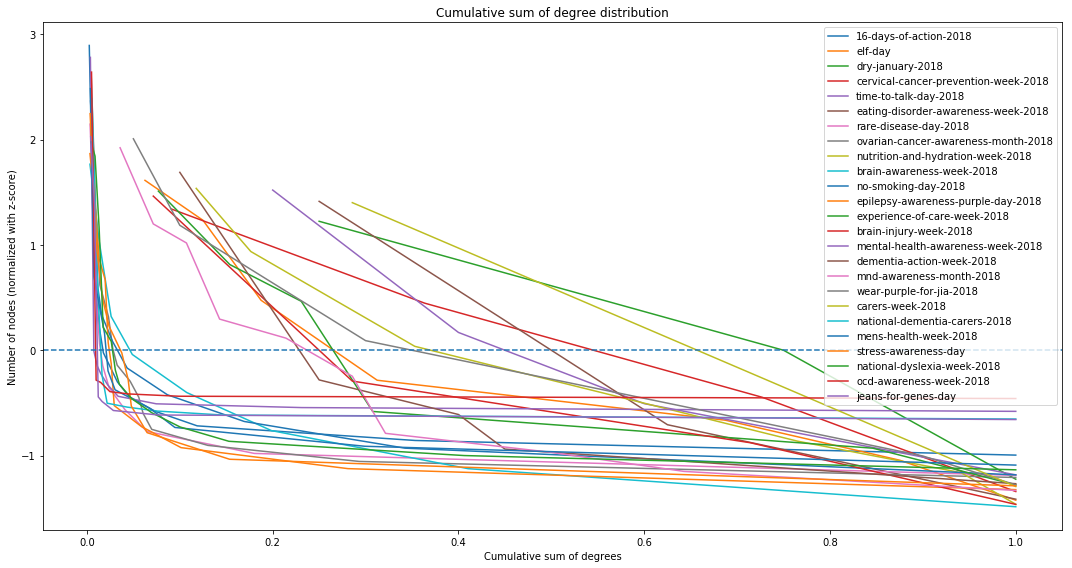

In [9]:
AnalysisHelper.plot_compare_cumsum_deg_dist(results);

Cumulative sum of degree distribution shows how the degree is distributed with respect to the number of nodes.

* Nodes with a lower degree (left on the plot) are typically way less than the ones with a high degree (right on the plot).

* Over the dotted line there's a number of node above the mean (the converse below the line) as per z-score.

* Z-score normalization for the number of nodes has been chosen because it preserves the range (maximum and minimum) and introduces the dispersion of the serie (standard deviation / variance)

\begin{align}
P(k) = \frac{\text{# nodes with degree >= k}}{\text{# nodes}}
\end{align}

Cumulative sum of degree distribution is more robust wrt the simple degree distribution because is less subject to small numbers. 

#### Common nodes

In [10]:
display(AnalysisHelper.get_common_nodes('community_detection', 'nodes', results))

,user_name
tenofficial,3
tiffanykairos,3
mentalhealth,3
bcmhouston,3
headwayuk,2
suenewse99,2
mason4233,2
trevorclower,2
youngmindsuk,2
thepurplelilac,2


Number of appearances of nodes across different events.

#### Users across events

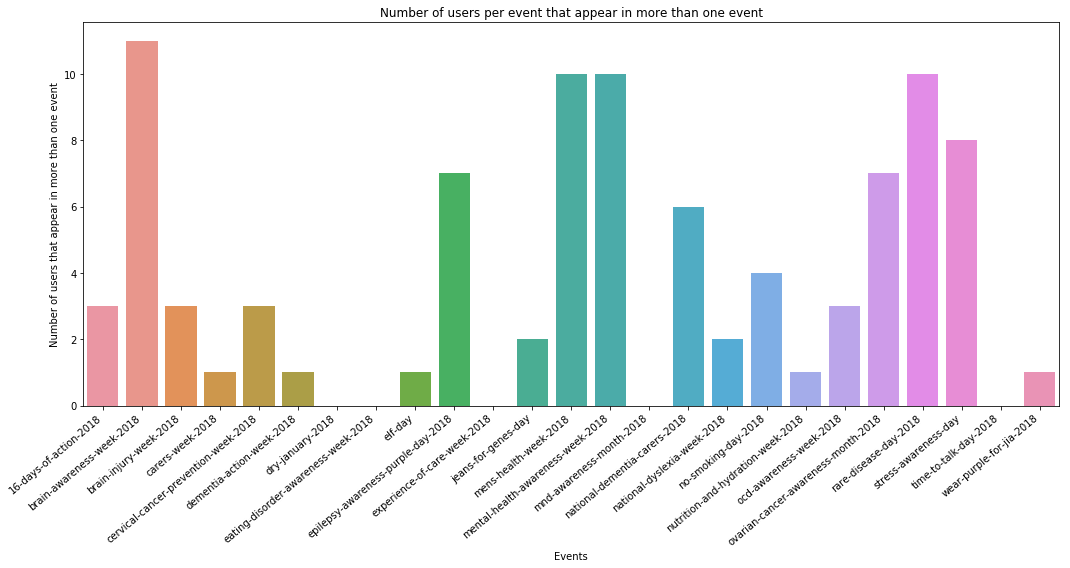

In [11]:
AnalysisHelper.plot_events_with_common_nodes('community_detection', 'nodes', results);

Number of users per event that appear in more than one event.